In [1]:
import pyarrow.parquet as pq
import pyarrow as pa
import pandas as pd
df_deduped = pq.ParquetFile('../data/financial_news/processed/sp500_financial_news_sentiment_deduped_0.8_4.parquet')

cur_df=None
for batch in df_deduped.iter_batches(batch_size=10000):
    df_batch = batch.to_pandas()
    if cur_df is None:
        cur_df = df_batch[['Date', 'Stock_symbol','article_title_pos_score', 'article_title_neg_score', 'article_title_neu_score']]
    else:
        cur_df = pd.concat([cur_df, df_batch[['Date', 'Stock_symbol','article_title_pos_score', 'article_title_neg_score', 'article_title_neu_score']]], ignore_index=True)

cur_df['Date']=pd.to_datetime(cur_df['Date'], utc=True)
cur_df['Date_et']=cur_df['Date'].dt.tz_convert('America/New_York')
cur_df['et_date']=cur_df['Date_et'].dt.date
cur_df['et_time']=cur_df['Date_et'].dt.time

In [2]:
cur_df=cur_df[(cur_df['et_date']>=pd.to_datetime('2010-01-01').date()) & (cur_df['et_date']<=pd.to_datetime('2023-12-31').date())]
cur_df=cur_df.dropna(subset=['et_date', 'et_time', 'article_title_pos_score'])

In [3]:
import exchange_calendars as xcals
nyse_cal = xcals.get_calendar("XNYS")

sched=nyse_cal.schedule.loc["2010-01-01":"2023-12-31"].copy()
sched['open_at']=sched['open'].dt.tz_convert('America/New_York')
sched['close_at']=sched['close'].dt.tz_convert('America/New_York')

In [4]:
stocknames=pd.read_parquet('../data/wrds/crsp_stocknames.parquet')
cur_df['Stock_symbol']=cur_df['Stock_symbol'].str.upper().str.strip()
stocknames=stocknames[stocknames['ticker'].isin(cur_df['Stock_symbol'].unique())].groupby('ticker').last().reset_index()
stock_permnos=stocknames.set_index('ticker')['permno'].to_dict()
print(stock_permnos)

dsf=pd.read_parquet('../data/wrds/crsp_dsf.parquet')
dsf=dsf[dsf['permno'].isin(stock_permnos.values())]
dsf['date']=pd.to_datetime(dsf['date']).dt.date
dsf['next']=dsf.groupby('permno')['date'].shift(-1)
price_dict={k:g.set_index('date').drop(columns=['permno']) for k, g in dsf.groupby('permno')}

{'A': 87432, 'AAL': 63845, 'AAP': 89217, 'AAPL': 14593, 'ABBV': 13721, 'ABC': 81540, 'ABMD': 75107, 'ABT': 20482, 'ABX': 71298, 'ACAS': 85271, 'ACGL': 82276, 'ACN': 89071, 'ACV': 69163, 'ADBE': 75510, 'ADCT': 50906, 'ADI': 60871, 'ADM': 10516, 'ADP': 44644, 'ADS': 89002, 'ADSK': 85631, 'ADT': 76805, 'AEE': 39116, 'AEP': 24109, 'AES': 76712, 'AET': 88845, 'AFL': 57904, 'AGC': 91974, 'AGN': 78916, 'AIG': 66800, 'AIT': 65859, 'AIV': 80711, 'AIZ': 90038, 'AJG': 38093, 'AKAM': 87299, 'AKS': 80303, 'AL': 24264, 'ALB': 80191, 'ALGN': 88860, 'ALK': 28804, 'ALL': 79323, 'ALLE': 82469, 'ALTR': 75577, 'ALXN': 83111, 'AM': 80071, 'AMAT': 14702, 'AMCC': 85522, 'AMD': 61241, 'AME': 85257, 'AMG': 85593, 'AMGN': 14008, 'AMH': 84406, 'AMP': 90880, 'AMT': 86111, 'AMZN': 84788, 'AN': 76282, 'ANET': 83946, 'ANF': 83976, 'ANSS': 83621, 'ANTM': 89179, 'ANV': 91976, 'AON': 61735, 'AOS': 75016, 'APA': 39490, 'APC': 70332, 'APD': 28222, 'APH': 84769, 'APO': 86365, 'APOL': 81138, 'APP': 91136, 'APTV': 76715, 'A

Set News Timing and Entry Points for Real Trading

In [5]:
import bisect

def snap_to_next_trading_day(d, idx):
    pos=bisect.bisect_left(idx, d)
    if pos==len(idx):
        return None
    return idx[pos]

def get_news_timing(et_date, et_time):
    try:
        key = pd.to_datetime(et_date)
        market_open=sched.loc[key, 'open_at'].time()
        market_close=sched.loc[key, 'close_at'].time()
        if et_time < market_open:
            return 'pre_market'
        elif et_time > market_close:
            return 'after_market'
        else:
            return 'during_market'
    except Exception as e: # 예외처리: 휴장일 등
        return 'after_market'
    
def get_next_trade_date(permno, d):
    if permno not in price_dict:
        return None
    idx = price_dict[permno].index
    if d in idx:
        nxt=price_dict[permno].loc[d, 'next']
        return None if pd.isna(nxt) else nxt
    else:
        return snap_to_next_trading_day(d, idx)
    
def calc_entry_date(row):
    permno=stock_permnos.get(row['Stock_symbol'], None)
    if permno is None:
        return None
    timing=row['news_timing']
    if timing=='pre_market':
        return row['et_date']
    elif timing in ('during_market', 'after_market'):
        return get_next_trade_date(permno, row['et_date'])
    else:
        return None

cur_df['news_timing']=cur_df.apply(lambda row: get_news_timing(row['et_date'], row['et_time']), axis=1)
cur_df['entry_date']=cur_df.apply(lambda row: calc_entry_date(row), axis=1)

In [6]:
print(cur_df['news_timing'].value_counts())

news_timing
after_market     1719828
pre_market          4707
during_market         63
Name: count, dtype: int64


In [7]:
print(cur_df['Stock_symbol'].value_counts())

Stock_symbol
GILD    11053
NVDA    10352
INTC     9856
MRK      9680
KO       9678
        ...  
LW          7
LIN         7
LIFE        6
EHC         6
I           1
Name: count, Length: 825, dtype: int64


Make Signal

In [8]:
# aggregate sentiment scores by et_date and Stock_symbol and news_timing
cur_df['sentiment_summary_score']=cur_df['article_title_pos_score'] - cur_df['article_title_neg_score']

cur_df_agg=cur_df.groupby(['entry_date', 'Stock_symbol']).agg(
    sentiment_score=('sentiment_summary_score', 'sum'),
    sentiment_count=('sentiment_summary_score', 'count')
).reset_index()

In [9]:
def calc_return(row):
    d=pd.to_datetime(row['entry_date']).date()
    permno=stock_permnos.get(row['Stock_symbol'], None)
    if permno is None:
        return None
    if permno not in price_dict:
        return None  # 해당 종목의 가격 데이터가 없으면 수익률 계산 불가
    if d in price_dict[permno].index:
        open_d=price_dict[permno].loc[d, 'open']
        close_d=price_dict[permno].loc[d, 'close']
        return (close_d - open_d) / open_d
    else: # 휴장일인 경우
        trading_dates = price_dict[permno].index.tolist()
        next_trading_date = snap_to_next_trading_day(d, trading_dates)
        if next_trading_date is None:
            return None  # 다음 거래일 데이터가 없으면 수익률 계산 불가
        next_open = price_dict[permno].loc[next_trading_date, 'open']
        next_close = price_dict[permno].loc[next_trading_date, 'close']
        return (next_close - next_open) / next_open

cur_df_agg['news_return']=cur_df_agg.apply(calc_return, axis=1)

In [10]:
cur_df_agg['news_return'].describe()

count    671510.000000
mean          0.000264
std           0.021496
min          -0.750268
25%          -0.008672
50%           0.000322
75%           0.009198
max           1.198830
Name: news_return, dtype: float64

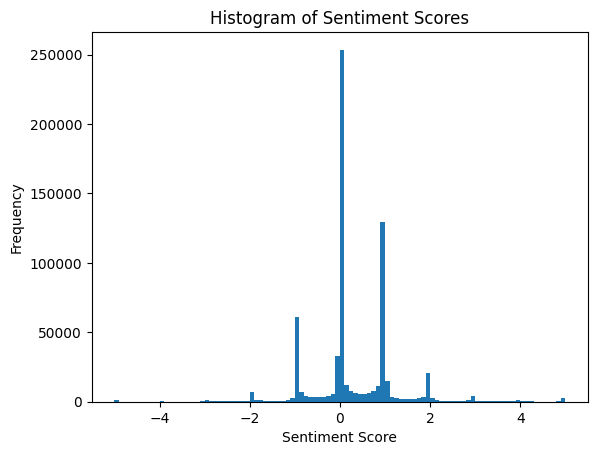

In [27]:
import matplotlib.pyplot as plt
plt.hist(cur_df_agg['sentiment_score'].dropna().clip(-5, 5), bins=100)
plt.title('Histogram of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

Check Intensity of Signal

In [11]:
import pyfixest as pf

cur_df_agg['permno']=cur_df_agg['Stock_symbol'].map(stock_permnos)
cur_df_agg['entry_date']=pd.to_datetime(cur_df_agg['entry_date'])
df2 = cur_df_agg[['news_return','sentiment_score','sentiment_count','permno','entry_date']]
res = pf.feols(
    "news_return ~ sentiment_score | permno + entry_date",
    data=df2,
    vcov={"CRV1": "permno + entry_date"}
)
print(res.summary())

/opt/homebrew/anaconda3/envs/financial_news/lib/python3.12/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 9 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(


###

Estimation:  OLS
Dep. var.: news_return, Fixed effects: permno+entry_date
Inference:  CRV1
Observations:  671501

| Coefficient     |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:----------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| sentiment_score |      0.001 |        0.000 |    10.653 |      0.000 |  0.001 |   0.001 |
---
RMSE: 0.019 R2: 0.193 R2 Within: 0.005 
None


10th percentile sentiment score: -0.9805608484777623
90th percentile sentiment score: 1.0379413654445673
Bottom 10% Sentiment Returns Description:
count    67054.000000
mean        -0.003879
std          0.027585
min         -0.453559
25%         -0.013867
50%         -0.001874
75%          0.008231
max          0.677871
Name: news_return, dtype: float64
Top 10% Sentiment Returns Description:
count    67300.000000
mean         0.003090
std          0.024044
min         -0.246923
25%         -0.007785
50%          0.001842
75%          0.012235
max          0.557789
Name: news_return, dtype: float64


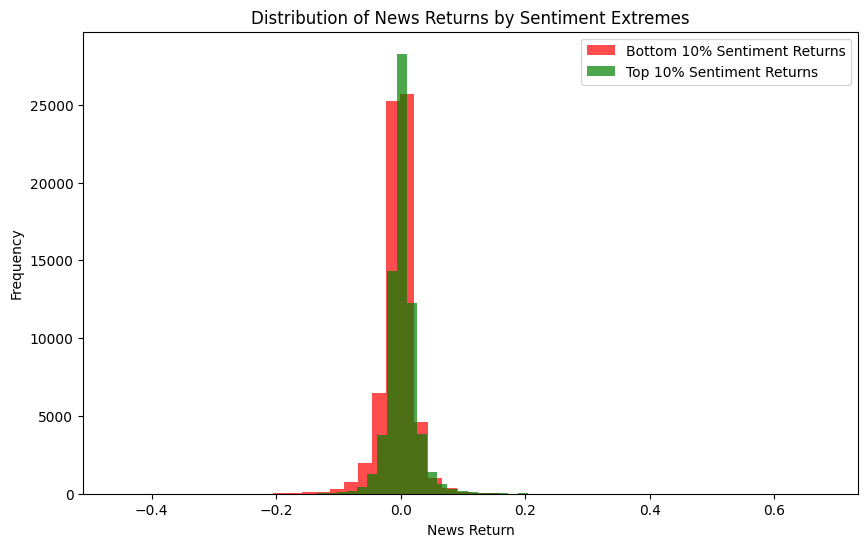

In [12]:
import matplotlib.pyplot as plt
sentiment_score_q10 = cur_df_agg['sentiment_score'].quantile(0.1)
sentiment_score_q90 = cur_df_agg['sentiment_score'].quantile(0.9)

print(f"10th percentile sentiment score: {sentiment_score_q10}")
print(f"90th percentile sentiment score: {sentiment_score_q90}")
sentiment_returns_q10 = cur_df_agg[cur_df_agg['sentiment_score'] <= sentiment_score_q10]['news_return']
sentiment_returns_q90 = cur_df_agg[cur_df_agg['sentiment_score'] >= sentiment_score_q90]['news_return']

print("Bottom 10% Sentiment Returns Description:")
print(sentiment_returns_q10.describe())
print("Top 10% Sentiment Returns Description:")
print(sentiment_returns_q90.describe())

plt.figure(figsize=(10,6))
plt.hist(sentiment_returns_q10.dropna(), bins=50, alpha=0.7, color='red', label='Bottom 10% Sentiment Returns')
plt.hist(sentiment_returns_q90.dropna(), bins=50, alpha=0.7, color='green', label='Top 10% Sentiment Returns')
plt.title('Distribution of News Returns by Sentiment Extremes')
plt.xlabel('News Return')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Run BackTest

In [13]:
print(cur_df_agg)

       entry_date Stock_symbol  sentiment_score  sentiment_count  news_return  \
0      2010-02-12           BX         0.959219                8     0.029719   
1      2010-02-12          COV         2.051225               11    -0.000202   
2      2010-02-12          CXO        -0.726449                2     0.005759   
3      2010-02-12          DAL        -1.726727               33     0.047904   
4      2010-02-12          DFS         2.059460               13     0.009295   
...           ...          ...              ...              ...          ...   
676292 2023-12-26          AMD         2.059136                8     0.023845   
676293 2023-12-27          AMD         1.010621                4     0.009328   
676294 2023-12-28          AMD         0.587377               10     0.013351   
676295 2023-12-29          AMD         0.966305                7    -0.013980   
676296 2024-01-02          AMD         2.482539                9    -0.039507   

        permno  
0        9

In [23]:
import os
import sys
sys.path.append('..')
from datetime import datetime
from src.backtest.backtest import backtest_sentiment_ls

# Long Only 
result = backtest_sentiment_ls(cur_df_agg, cost_bps_one_way=13.0, weight_mode="score", long_q=0.95, short_q=-1, min_names_per_side=5.0, target_col='sentiment_score', weight_cap=1.0)
print(result["stats"])
result["daily"].tail()

{'days': 3369, 'avg_daily_gross': 0.0037449138560647416, 'avg_daily_cost': 0.0025999999999999994, 'avg_daily_net': 0.001144913856064742, 'vol_daily_net': 0.013501492837233883, 'sharpe_net': 1.3461432919709222, 'cum_return_net': 33.82622537653974, 'avg_turnover': 2.0, 'maximum_drawdown': 0.36833254580666547}


,gross_ret,turnover,cost,net_ret,equity_net
entry_date,,,,,
2023-12-12,0.006098,2.0,0.0026,0.003498,34.673969
2023-12-13,0.008531,2.0,0.0026,0.005931,34.879616
2023-12-14,-0.001383,2.0,0.0026,-0.003983,34.740704
2023-12-15,0.001037,2.0,0.0026,-0.001563,34.686416
2023-12-18,0.006631,2.0,0.0026,0.004031,34.826225


In [15]:
winrate=result["daily"][result["daily"]["net_ret"] > 0].shape[0] / result["daily"].shape[0]
print("Winrate:", winrate)

Winrate: 0.5329272934906738


Check Signal Stability

In [16]:
import numpy as np

ic_daily = (
    cur_df_agg
    .groupby('entry_date')
    .apply(lambda g: g['sentiment_score'].corr(g['news_return']))
)

print("Mean Daily IC:", ic_daily.mean())
print("IC Std:", ic_daily.std())
print("IC IR:", ic_daily.mean() / ic_daily.std())

print('IC By Year:', ic_daily.groupby(ic_daily.index.year).mean())

hit_ratio = np.mean((cur_df_agg['sentiment_score'] * cur_df_agg['news_return']) > 0)
print("Hit Ratio:", hit_ratio)


Mean Daily IC: 0.07301571920642959
IC Std: 0.11701055627178489
IC IR: 0.6240096751342091
IC By Year: entry_date
2010    0.081503
2011    0.059177
2012    0.098803
2013    0.066064
2014    0.043830
2015    0.079299
2016    0.073808
2017    0.066275
2018    0.077660
2019    0.120733
2020    0.093520
2021    0.047219
2022    0.064548
2023    0.049890
2024         NaN
dtype: float64
Hit Ratio: 0.5202063590404807


/Users/juho/.local/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3057: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/juho/.local/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/juho/.local/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/var/folders/6t/lm1t6gy11tlbpmk1mcj_r0p80000gn/T/ipykernel_23037/1708500097.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g['sentiment_score'].corr(g['news_return'])

In [17]:
# Return Stability by Decile

return_top_decile = cur_df_agg.groupby(cur_df_agg['entry_date'].dt.year).apply(
    lambda g: g.loc[g['sentiment_score'] >= g['sentiment_score'].quantile(0.9), 'news_return'].mean()
)
return_bottom_decile = cur_df_agg.groupby(cur_df_agg['entry_date'].dt.year).apply(
    lambda g: g.loc[g['sentiment_score'] <= g['sentiment_score'].quantile(0.1), 'news_return'].mean()
)
print("Return Top Decile by Year:", return_top_decile)
print("Return Bottom Decile by Year:", return_bottom_decile)

# stock num Stability

stock_num_by_year = cur_df_agg.groupby(cur_df_agg['entry_date'].dt.year)['Stock_symbol'].nunique()
print("Stock Num by Year:", stock_num_by_year)

Return Top Decile by Year: entry_date
2010    0.004956
2011    0.001616
2012    0.004233
2013    0.003507
2014    0.001548
2015    0.003028
2016    0.003628
2017    0.001765
2018    0.001285
2019    0.004727
2020    0.007375
2021    0.002355
2022    0.002388
2023    0.002129
2024   -0.039507
dtype: float64
Return Bottom Decile by Year: entry_date
2010   -0.003422
2011   -0.003471
2012   -0.003175
2013   -0.001573
2014   -0.001585
2015   -0.002001
2016   -0.001625
2017   -0.002209
2018   -0.004468
2019   -0.007325
2020   -0.013683
2021   -0.002292
2022   -0.003123
2023   -0.001490
2024   -0.039507
dtype: float64
Stock Num by Year: entry_date
2010    542
2011    567
2012    579
2013    587
2014    594
2015    612
2016    612
2017    597
2018    589
2019    582
2020    661
2021    362
2022    373
2023    410
2024      1
Name: Stock_symbol, dtype: int64


Show Bench Mark

In [28]:
# Load BenchMark

benchmark_df = pd.read_parquet('../data/wrds/crsp_dsi.parquet')
result_start=result["daily"].index.min()
benchmark_df=benchmark_df[pd.to_datetime(benchmark_df['date']).dt.date>=result_start]
benchmark_df['date']=pd.to_datetime(benchmark_df['date']).dt.date
benchmark_df=benchmark_df.set_index('date').sort_index()
benchmark_df['pnl']=benchmark_df['vwretd'].cumsum().apply(lambda x: np.exp(x))

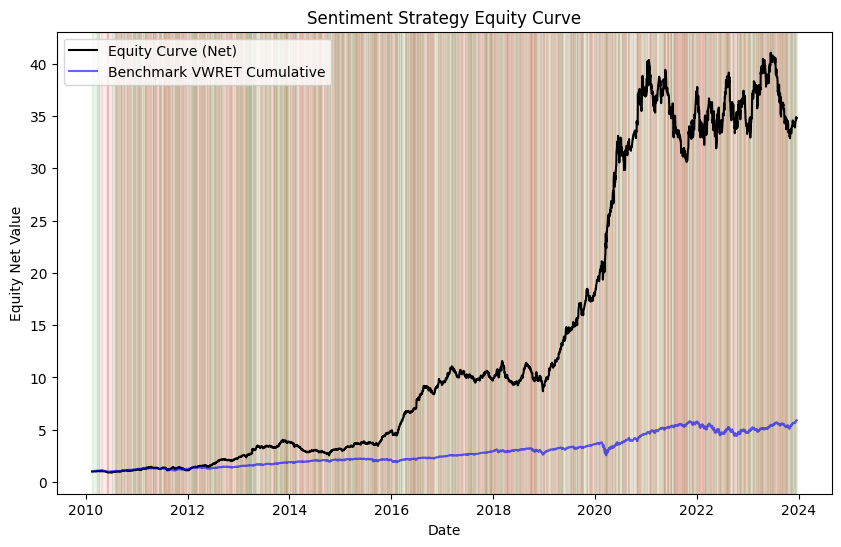

In [29]:
import numpy as np

daily = result["daily"].copy()
daily.index = pd.to_datetime(daily.index)

plt.figure(figsize=(10,6))
plt.plot(daily["equity_net"], label="Equity Curve (Net)", color="black")
plt.plot(benchmark_df['pnl'].reindex(daily.index), label="Benchmark VWRET Cumulative", color="blue", alpha=0.6)

sign = np.sign(daily["net_ret"].values)
change_idx = np.where(np.diff(sign) != 0)[0] + 1
segments = np.split(np.arange(len(daily)), change_idx)

for seg in segments:
    start = daily.index[seg[0]]
    end = daily.index[seg[-1]]
    color = 'green' if daily["net_ret"].iloc[seg[0]] > 0 else 'red'
    plt.axvspan(start, end, color=color, alpha=0.08)

plt.title("Sentiment Strategy Equity Curve")
plt.xlabel("Date")
plt.ylabel("Equity Net Value")
plt.legend()
plt.show()


Check Alpha

In [20]:
print(daily['net_ret'].isna().sum())
print(benchmark_df['pnl'].reindex(daily.index).isna().sum())

0
0


In [21]:
import statsmodels.api as sm

daily.index=pd.to_datetime(daily.index)
benchmark_df.index=pd.to_datetime(benchmark_df.index)
intersect_index=daily.index.intersection(benchmark_df.index)
X=sm.add_constant(benchmark_df['vwretd'].reindex(intersect_index).values)
Y=(daily['net_ret'].reindex(intersect_index).values)

model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     713.2
Date:                Sun, 08 Feb 2026   Prob (F-statistic):          3.31e-139
Time:                        15:32:27   Log-Likelihood:                 7938.5
No. Observations:                2627   AIC:                        -1.587e+04
Df Residuals:                    2625   BIC:                        -1.586e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.000      4.864      0.0

Check Market Neutral Performance

In [22]:
cur_df_agg_cp=cur_df_agg.copy()
cur_df_agg_cp['news_return']=cur_df_agg_cp['news_return']-model.params[1]*benchmark_df['vwretd'].reindex(cur_df_agg_cp['entry_date']).values

result_cp = backtest_sentiment_ls(cur_df_agg_cp, cost_bps_one_way=13.0, weight_mode="score", long_q=0.95, short_q=-1, min_names_per_side=5.0, target_col='sentiment_score', weight_cap=0.25)
print(result_cp["stats"])

{'days': 3369, 'avg_daily_gross': 0.0034119033276654685, 'avg_daily_cost': 0.0025999999999999994, 'avg_daily_net': 0.0008119033276654688, 'vol_daily_net': 0.011560615576977873, 'sharpe_net': 1.1148684666444881, 'cum_return_net': 11.320702899811632, 'avg_turnover': 2.0, 'maximum_drawdown': 0.37817997688705624}
